In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import datetime
from collections import OrderedDict
from scipy import stats
import corner
from sklearn.preprocessing import MinMaxScaler

from matplotlib.pyplot import figure
from IPython.display import HTML


plt.style.use('seaborn')
%matplotlib inline

### Resources used: 
1. [Correlation: Pearson/Spearman](https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/)
2. [Multivariate Analysis (Outlier detection)](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Anomaly_Detection_for_Dummies.ipynb?source=post_page---------------------------)
    * [Medium article](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1)
3. [PyOD Tutorial (Outlier detection)](https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/)
4. [Understanding Outliers](https://stats.stackexchange.com/questions/200534/is-it-ok-to-remove-outliers-from-data/200923)
5. [Denisty Based Algorithms for Outlier Detection](https://towardsdatascience.com/density-based-algorithm-for-outlier-detection-8f278d2f7983)

### The scatter plot probably indicates some outliers 
* Removing outliers is very debatable and we have to go through with care

### According to multiple sources
* You can remove outliers in a sensitivity analysis, though, and compare the results of the two analyses. In science, often you discover new stuff precisely when focusing on such outliers.
* Should only remove outliers when you can argue (with almost certainty) why such points are invalid, this is usually not the case because one doesn't know the situation this observation may be recorded wrong or what the situation was on the spot. Even more to say one doesn't understand the underlying information well enough unlesss you are a CBP patrol agent. 
* In addition, The problem with removing outliers, is that to determine which points are outliers, you need to have a good model of what is or is not "good data". If you are unsure about the model (which factors should be included, what structure does the model have, what are the assumptions of the noise, ...), then you cannot be sure about your outliers. Those outliers might just be samples that are trying to tell you that your model is wrong. In other words: removing outliers will reinforce your (incorrect!) model, instead of allowing you to obtain new insights!
* Note: In our scenario we aren't really modelling anything and that we don't have some model metric to check if the outliers are making the model better. 
* The only thing we can consider is, did the efficiency score change after removing these outliers? 





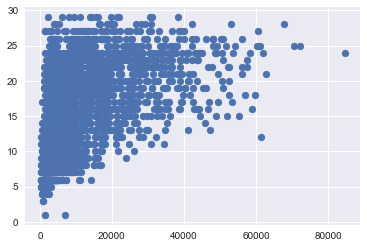

In [2]:
df = pd.read_csv('AirportWaitTimes_new.csv')
df['Date_new'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date_new'].dt.month
df['Day'] = df['Date_new'].dt.day
df['Day_of_week'] = df['Date_new'].dt.weekday
df['Actual'] = df['Total']-df['Excluded']
df = df[(df['Average Wait Time'] != 0 ) & (df['Booths'] != 0)]

df['Metric:Efficiency1'] = (df['Average Wait Time']*(df['Actual']))/df['Booths']

df = df.reset_index(inplace = False, drop = True)
plt.scatter(df['Average Wait Time']*df['Actual'],df['Booths'])

plt.show()
df['Total Time'] = df['Average Wait Time']*df['Actual']
olddf = df

### Observation of distribution and correlation values
* Not normally distributed
* Have positive relationship, but not linear 
* The spearman correlation value 0.57 kind of indicates some sort of non linear relationship (Then again the value isn't high so we can't conclude much either)

In [3]:
np.cov(df['Total Time'], df['Booths'])

array([[1.41560247e+08, 3.64413896e+04],
       [3.64413896e+04, 3.92492010e+01]])

### A check for linear relationship

In [4]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df['Total Time'], df['Booths'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.489


### A quick check for non linear relationship

In [5]:
from scipy.stats import spearmanr
corr, pvalue = spearmanr(df['Total Time'], df['Booths'])
print('Spearmans correlation: %.3f' % corr, 'p-value: %.20f is less than 0.05, reject null hypothesis (uncorrelated)' %pvalue)
print('Moderate correlation and statistically significant that there exist a relationship between our two variables')

Spearmans correlation: 0.573 p-value: 0.00000000000000000000 is less than 0.05, reject null hypothesis (uncorrelated)
Moderate correlation and statistically significant that there exist a relationship between our two variables


### Distribution of the two variables observed

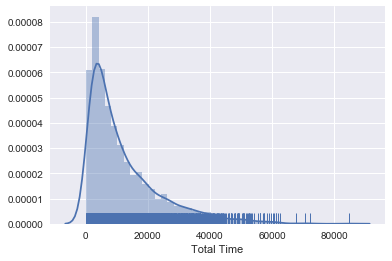

In [6]:
# total time = average time * actual number of passengers
sns.distplot(df['Total Time'], kde=True, rug=True);

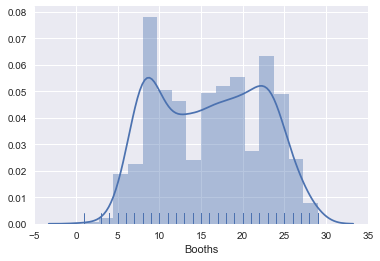

In [7]:
sns.distplot(df['Booths'], kde=True, rug=True);


# Proximity Based Unsupervised Outlier detection
* An unsupervised outlier detection method expects that normal objects follow a pattern far more frequently than outliers.
* Normal objects may not share any strong patterns, but the collective outliers may share high similarity in a small area
* Given a set of objects in feature space, a distance measure can be used to quantify the similarity between objects. Intuitively, objects that are far from others can be regarded as outliers. Proximity-based approaches assume that the proximity of an outlier object to its nearest neighbors significantly deviates from the proximity of the object to most of the other objects in the data set.
* The proximity-based algorithm can be divided into distance-based (an object is an outlier if its neighborhood doesn’t have enough points) and density-based methods (An object is an outlier if its density relatively much lower than that of its neighbours)


### Use MinMaxScaler from sklearn.preprocessing to scale data between 0 and 1
* Why do we scale? It is better to scale when working with machinelearning algorithms. In this case we are using two proximity based algorithms that use Eucledian distance between two data points in their computations, this is a problem.

* in particular k-nearest neighbors uses an Euclidean distance measure, which is sensitive to magnitudes and hence should be scaled for all features to weigh in equally.

In [8]:
minmax = MinMaxScaler(feature_range=(0, 1))
outlier1 = df
outlier1[['Total Time', 'Booths']] = minmax.fit_transform(outlier1[['Total Time', 'Booths']])
outlier1[['Total Time', 'Booths']].head()

,Total Time,Booths
0,0.007835,0.250000
1,0.019197,0.250000
2,0.207459,0.892857
3,0.131323,0.928571
4,0.046832,0.785714


## Cluster Based Local Outliers 
* k-means 
* Cluster Based Local Outlier Factors (CBLOF)

OUTLIERS: 23 INLIERS: 2237


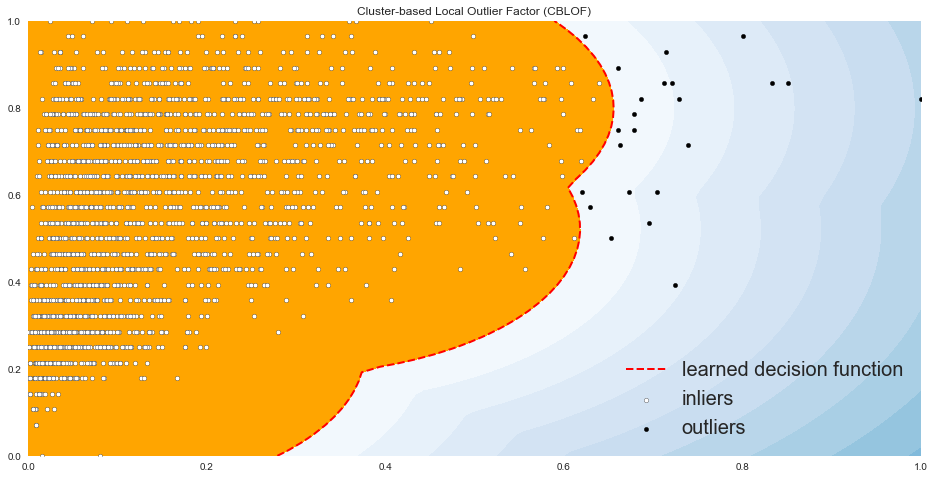

In [9]:
from pyod.models.cblof import CBLOF
X = outlier1[['Total Time', 'Booths']].values
outlier_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(-1, 1,100), np.linspace(-1, 1,100))
clf = CBLOF(contamination=outlier_fraction,check_estimator=False, random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(16, 8))


outlier1['outlier'] = y_pred.tolist()

# sales - inlier feature 1,  profit - inlier feature 2
inliers_Total_Time = np.array(outlier1['Total Time'][outlier1['outlier'] == 0]).reshape(-1,1)
inliers_Booths = np.array(outlier1['Booths'][outlier1['outlier'] == 0]).reshape(-1,1)

# sales - outlier feature 1, profit - outlier feature 2
outliers_Total_Time = outlier1['Total Time'][outlier1['outlier'] == 1].values.reshape(-1,1)
outliers_Booths = outlier1['Booths'][outlier1['outlier'] == 1].values.reshape(-1,1)

print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 20),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_Total_Time, inliers_Booths, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_Total_Time, outliers_Booths, c='black',s=20, edgecolor='black')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

# get the index so we can use for comparison later
outlier1_index = outlier1.loc[outlier1['outlier'] == 1].index

# K Nearest Neighbour 

OUTLIERS:  21 INLIERS:  2239


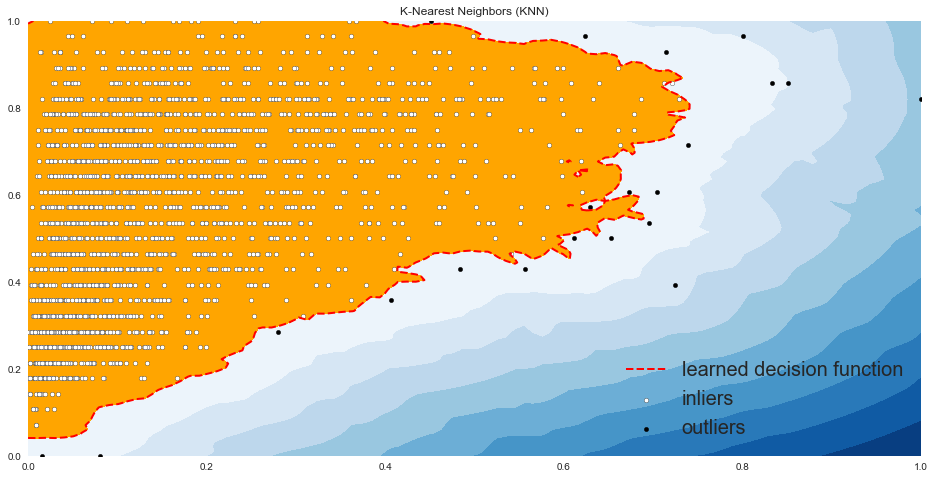

In [10]:
from pyod.models.knn import KNN

outlier2 = df 
outlier2[['Total Time', 'Booths']] = minmax.fit_transform(outlier2[['Total Time', 'Booths']])

X = outlier2[['Total Time', 'Booths']].values
outlier_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination=outlier_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(16 , 8))
# copy of dataframe

outlier2['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_Total_Time = np.array(outlier2['Total Time'][outlier2['outlier'] == 0]).reshape(-1,1)
inliers_Booths = np.array(outlier2['Booths'][outlier2['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_Total_Time = outlier2['Total Time'][outlier2['outlier'] == 1].values.reshape(-1,1)
outliers_Booths = outlier2['Booths'][outlier2['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_Total_Time, inliers_Booths, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_Total_Time, outliers_Booths, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K-Nearest Neighbors (KNN)')
plt.show();

# get index for comparison! 
outlier2_index = outlier2.loc[outlier2['outlier'] == 1].index

# We found the outliers to be located at 
* CBLOF: [`64`, 134, 148, `175`, `197`, 209, `213`, `281`, `313`, 394, 445, `449`, `463`, `734`, 1268, 1282, 1299, `1466`, 1472, `1476`, `1521`, 1979, `2098`]
* KNN: [`64`, `175`, `197`, 200, `213`, `281`, `313`, `449`, `463`, 586,`734`, 985, 1147, `1466`, 1476, `1521`, 1568, 1699, `2098`, 2151, 2241]
* The highlighted ones are the outliers that appear in both methods

In [11]:
# Lets just combine the outliers from both methods using a union
def union(a, b):
    return list(set(a) | set(b))
outlier_list = union(outlier1_index.to_list(),outlier2_index.to_list())
len(outlier_list)

31

## Observing each outlier
* Remember we don't usually remove outliers without some knowledge of the industry 
* However for this case its just to play around with `PyOD` and will remove outliers on what makes sense

* Most of the outliers made some sense in why it is considered an outlier. I also compared these outliers to the average efficiency table in the other notebook and noticed that all the values are high above the average efficiency value for the respective day of the week and hour. 
* This will definitely increase the efficiency table and more likely tell a more truthful table. 
* I've also noticed some patterns in the outliers. There is a bout a third of the outliers are in the time interval 6 to 8 pm on saturday or sunday. This also justifies the fact that these two days are the most inefficient days for Custom Border Patrols. 
* Lastly I also looked into historical data to see if there are many cases that are above 3000 efficiency at the particular time interval 6 to 8 pm on a saturday and it actually isn't that frequent. Meaning 2017-2018 had a few awful weekends! 

In [12]:
df = pd.read_csv('AirportWaitTimes_new.csv')
df['Date_new'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date_new'].dt.month
df['Day'] = df['Date_new'].dt.day
df['Day_of_week'] = df['Date_new'].dt.weekday
df['Actual'] = df['Total']-df['Excluded']
df = df[(df['Average Wait Time'] != 0 ) & (df['Booths'] != 0)]

df['Metric:Efficiency1'] = (df['Average Wait Time']*(df['Actual']))/df['Booths']

df = df.reset_index(inplace = False, drop = True)
df['Total Time'] = df['Average Wait Time']*df['Actual']

outlier = df[df.index.isin(outlier_list)]

### Also note that these outliers take up 48% of the 120 plus wait times meaning it is usually not likely to have such long wait times and more or less not as important. But if we want to take into consideration long custom wait time should be heavily penalised and not treated the same as usual custom wait times. Conusumer's sentiment changes when experience excessive wait times, which won't be good for CBP. 

## Lets do the same comparison between efficiency tables done in the previous notebook
* The comparison will use the old percentiles without dropping outliers to high light the dataframe

In [17]:
# Setting up efficiency values 
# lets call it additional instead of what we called df_full in the previous notebook
additional = pd.read_csv("combined_2010-2016-2019.csv")
convert_day = {0: 'Monday', 1: 'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

df = df.drop(df.index[outlier_list])

year2017 = df[df['Date_new'].dt.year == 2017]
year2018 = df[df['Date_new'].dt.year == 2018]

med = round(additional[(additional['Hour'] == '0100 - 0200')]['Metric:Efficiency1'].median())

efficiency_tableolddf = round(olddf.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency1']).unstack()
efficiency_tableolddf = efficiency_tableolddf.drop('0200 - 0300', axis = 0)
efficiency_tableolddf.fillna(med, inplace =True)

efficiency_tabledf = round(df.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency1']).unstack()
efficiency_table2017 = round(year2017.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency1']).unstack()
efficiency_table2018 = round(year2018.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency1']).unstack()
efficiency_table2018.fillna(med, inplace =True)
efficiency_table2018

efficiency_table2017 = efficiency_table2017.drop('0200 - 0300', axis = 0)
efficiency_table2017.fillna(med, inplace =True)

efficiency_tabledf = round(df.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency1']).unstack()
efficiency_tabledf = efficiency_tabledf.drop('0200 - 0300', axis = 0)
efficiency_tabledf.fillna(med, inplace =True)



### Checking percentile values

In [141]:
np.percentile(efficiency_tabledf.values.reshape(1,-1), 25)

456.5

In [142]:
np.percentile(efficiency_tabledf.values.reshape(1,-1), 75)

805.5

In [143]:
np.percentile(efficiency_tabledf.values.reshape(1,-1), 99)

1468.25

In [144]:
np.percentile(efficiency_tabledf.values.reshape(1,-1), 1)

229.25

In [18]:
def highlight_min(s):    
    is_min = s <= 456.5 # efficiency score of roughly 375
    return ['background-color: orange' if v else '' for v in is_min]

def highlight_max(s):    
    is_max = s >= 805.5
    return ['background-color: red' if v else '' for v in is_max]

def max_val(s):    
    is_max = s >= 1468.25
    return ['background-color: cyan' if v else '' for v in is_max]

def min_val(s):    
    is_max = s <= 229.25
    return ['background-color: lightgreen' if v else '' for v in is_max]
a= round(additional.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency1']).unstack()

## New 2017 to 2018 Efficiency Table

In [19]:
efficiency_tabledf.rename(columns = convert_day).style.apply(highlight_min).apply(highlight_max).apply(min_val).apply(max_val)


Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
0000 - 0100,262,363,270,254,511,676,226
0100 - 0200,485,364,476,219,249,315,262
0800 - 0900,519,815,790,690,555,651,513
0900 - 1000,908,922,714,831,832,1131,796
1000 - 1100,610,607,658,780,668,825,556
1100 - 1200,431,561,299,413,259,354,374
1200 - 1300,1068,898,966,996,835,934,833
1300 - 1400,774,673,669,775,782,717,842
1400 - 1500,686,804,488,877,738,541,568


In [20]:
b= efficiency_tabledf
b = b.rename(columns = convert_day)
b['Hour_average'] =b.mean(axis =1)
b.loc['Day_average'] = b.mean()
b.style.apply(highlight_min).apply(highlight_max).apply(min_val).apply(max_val)

Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Hour_average
Hour,,,,,,,,
0000 - 0100,262,363,270,254,511,676,226,366
0100 - 0200,485,364,476,219,249,315,262,338.571
0800 - 0900,519,815,790,690,555,651,513,647.571
0900 - 1000,908,922,714,831,832,1131,796,876.286
1000 - 1100,610,607,658,780,668,825,556,672
1100 - 1200,431,561,299,413,259,354,374,384.429
1200 - 1300,1068,898,966,996,835,934,833,932.857
1300 - 1400,774,673,669,775,782,717,842,747.429
1400 - 1500,686,804,488,877,738,541,568,671.714


# New 2017 Efficiency Table

In [21]:
efficiency_table2017.rename(columns = convert_day).style.apply(highlight_min).apply(highlight_max).apply(min_val).apply(max_val)

Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
0000 - 0100,183,260,131,227,307,270,186
0100 - 0200,810,348,476,219,213,322,314
0800 - 0900,503,966,1124,567,904,779,716
0900 - 1000,913,954,702,830,608,852,543
1000 - 1100,590,681,732,1017,696,900,519
1100 - 1200,477,836,321,438,287,278,387
1200 - 1300,834,807,772,856,594,679,562
1300 - 1400,800,622,581,622,864,507,607
1400 - 1500,395,844,445,587,527,479,226


# New 2018 Efficiency Table

In [22]:
efficiency_table2018.rename(columns = convert_day).style.apply(highlight_min).apply(highlight_max).apply(min_val).apply(max_val)

Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
0000 - 0100,367,501,479,282,1126,920,335
0100 - 0200,160,414,219,219,357,302,109
0800 - 0900,529,664,456,813,381,396,473
0900 - 1000,904,891,725,832,1131,1438,1162
1000 - 1100,658,543,541,496,601,750,675
1100 - 1200,379,311,275,386,225,424,362
1200 - 1300,1302,982,1199,1149,1147,1168,1223
1300 - 1400,750,720,773,955,685,909,1097
1400 - 1500,888,786,521,1141,929,593,767


In [23]:
np.percentile(efficiency_tabledf.values.reshape(1,-1), 25) 

456.5

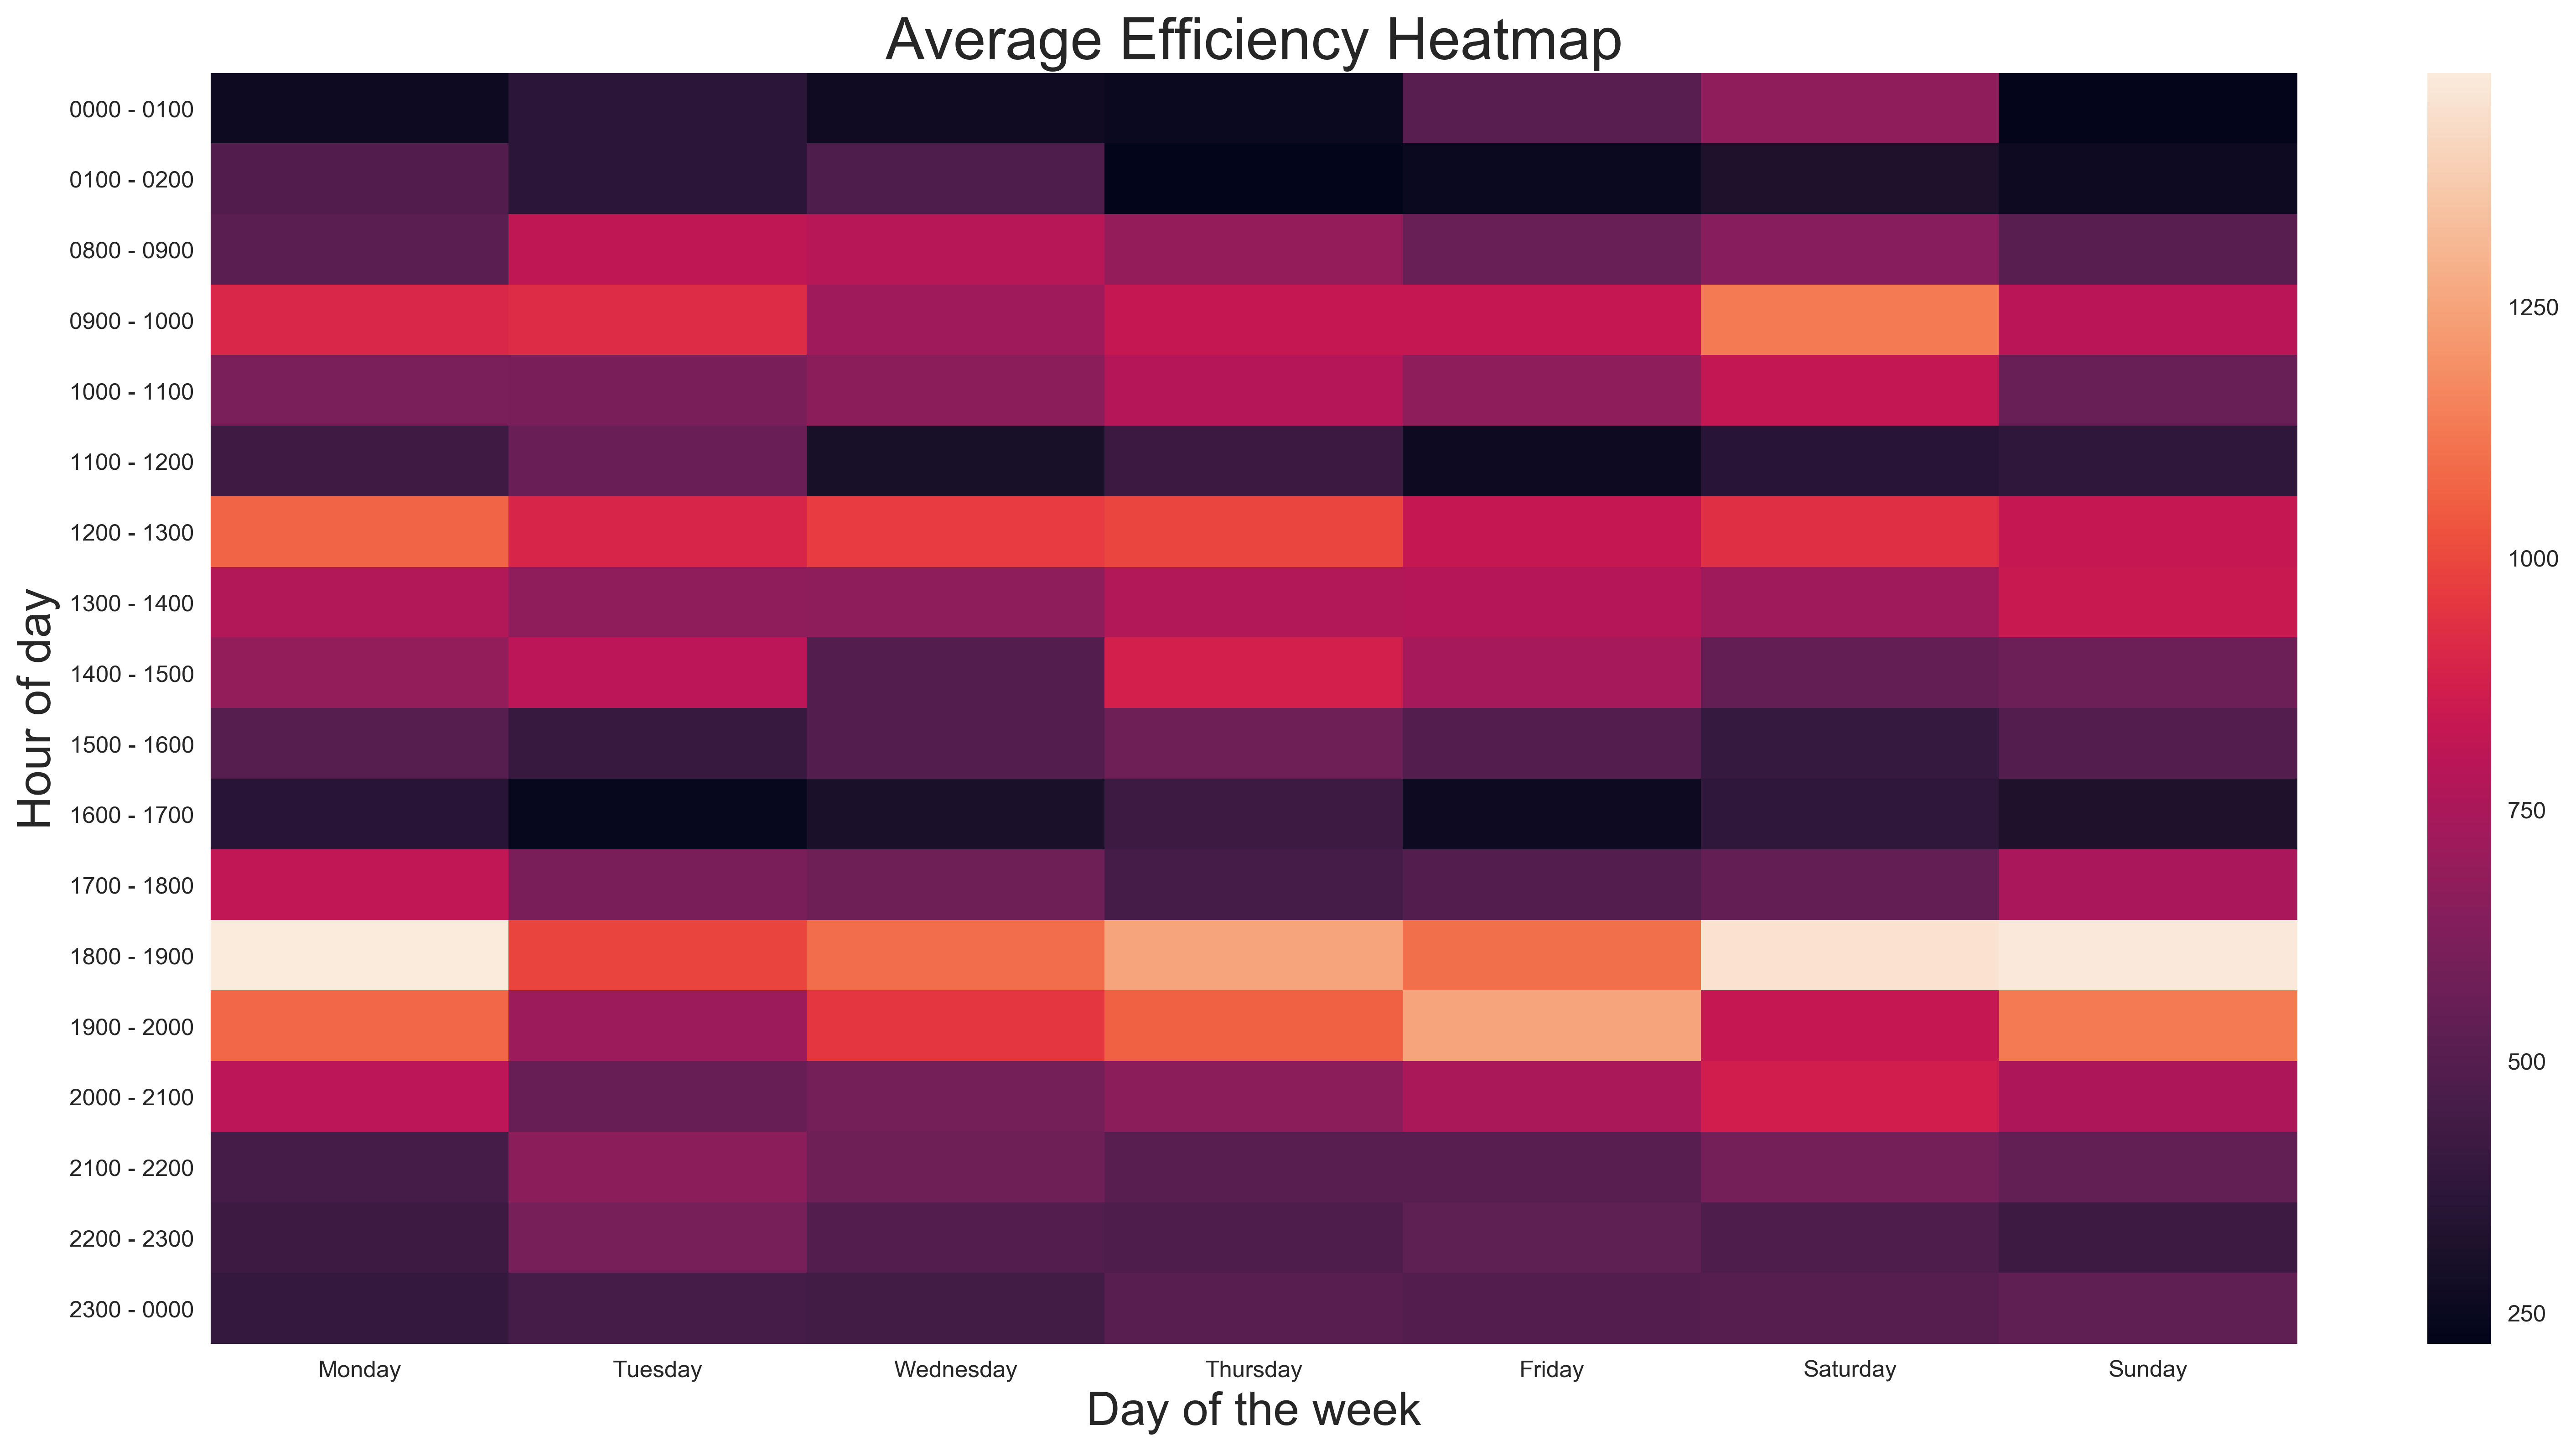

In [24]:
figure(num=1, figsize=(20, 10), dpi=369, facecolor='w', edgecolor='k')
heatmap_efficiency_df = efficiency_tabledf.rename(columns = convert_day)
#'Day_of_week', fill_value=0)
ax = plt.axes()
sns.heatmap(heatmap_efficiency_df, ax=ax)

ax.set_title('Average Efficiency Heatmap', fontsize=25)
ax.set_xlabel("Day of the week", fontsize = 20)
ax.set_ylabel("Hour of day", fontsize = 20)

plt.show()

In [25]:
a= a.drop('0200 - 0300', axis = 0)
a= a.drop('0600 - 0700', axis = 0)
a= a.drop('0700 - 0800', axis = 0)
a.rename(columns = convert_day).style.apply(highlight_min).apply(highlight_max).apply(min_val).apply(max_val)

Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Hour,,,,,,,
0000 - 0100,267,269,432,329,339,333,375
0100 - 0200,297,405,293,263,236,222,197
0800 - 0900,413,334,447,357,498,560,551
0900 - 1000,828,882,893,798,787,873,810
1000 - 1100,710,862,811,805,860,997,859
1100 - 1200,596,621,481,724,658,586,699
1200 - 1300,774,813,727,739,726,849,750
1300 - 1400,852,614,714,743,785,882,780
1400 - 1500,565,540,450,599,553,614,625


# Change 

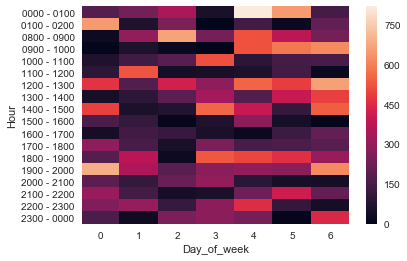

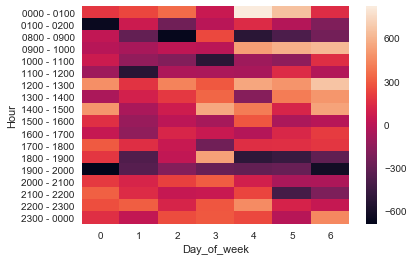

Day_of_week,0,1,2,3,4,5,6
Hour,,,,,,,
0000 - 0100,184,241,348,55,819,650,149
0100 - 0200,650,66,257,0,144,20,205
0800 - 0900,26,302,668,246,523,383,243
0900 - 1000,9,63,23,2,523,586,619
1000 - 1100,68,138,191,521,95,150,156
1100 - 1200,98,525,46,52,62,146,25
1200 - 1300,468,175,427,293,553,489,661
1300 - 1400,50,98,192,333,179,402,490
1400 - 1500,493,58,76,554,402,114,541


In [26]:
def highlight_min(s):    
    is_min = s <= np.percentile(delta.abs().values.reshape(1,-1), 5) # efficiency score of roughly 375
    return ['background-color: orange' if v else '' for v in is_min]

def highlight_max(s):    
    is_max = s >= np.percentile(delta.abs().values.reshape(1,-1), 85)
    return ['background-color: red' if v else '' for v in is_max]

def max_val(s):    
    is_max = s >= np.percentile(delta.abs().values.reshape(1,-1), 99)
    return ['background-color: cyan' if v else '' for v in is_max]

def min_val(s):    
    is_max = s <= np.percentile(delta.abs().values.reshape(1,-1), 1)
    return ['background-color: lightgreen' if v else '' for v in is_max]

delta = efficiency_table2018-efficiency_table2017
# Note We use the absolute value function to see the change
sns.heatmap(delta.abs())
plt.show()

sns.heatmap(delta)
plt.show()
delta.abs().style.apply(highlight_max).apply(max_val)

# Observe the change 2018 2017

In [27]:
def highlight_min(s):    
    is_min = s <= np.percentile(delta.values.reshape(1,-1), 25) # efficiency score of roughly 375
    return ['background-color: orange' if v else '' for v in is_min]

def highlight_max(s):    
    is_max = s >= np.percentile(delta.values.reshape(1,-1), 70)
    return ['background-color: red' if v else '' for v in is_max]

def max_val(s):    
    is_max = s >= np.percentile(delta.values.reshape(1,-1), 99)
    return ['background-color: cyan' if v else '' for v in is_max]

def min_val(s):    
    is_max = s <= np.percentile(delta.values.reshape(1,-1), 1)
    return ['background-color: lightgreen' if v else '' for v in is_max]

In [28]:
b= efficiency_table2018
b = b.rename(columns = convert_day)
b['Hour_average'] =b.mean(axis =1)
b.loc['Day_average'] = b.mean()

c= efficiency_table2017
c = c.rename(columns = convert_day)
c['Hour_average'] =c.mean(axis =1)
c.loc['Day_average'] = c.mean()
delta = round(b-c)

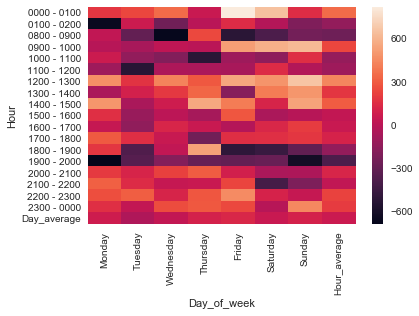

In [190]:
sns.heatmap(delta)
plt.show()

In [199]:
delta.rename(columns = convert_day).style.apply(highlight_max).apply(max_val).apply(highlight_min).apply(min_val)

Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Hour_average
Hour,,,,,,,,
0000 - 0100,184,241,348,55,819,650,149,349
0100 - 0200,-650,66,-257,0,144,-20,-205,-132
0800 - 0900,26,-302,-668,246,-523,-383,-243,-264
0900 - 1000,-9,-63,23,2,523,586,619,240
1000 - 1100,68,-138,-191,-521,-95,-150,156,-124
1100 - 1200,-98,-525,-46,-52,-62,146,-25,-95
1200 - 1300,468,175,427,293,553,489,661,438
1300 - 1400,-50,98,192,333,-179,402,490,184
1400 - 1500,493,-58,76,554,402,114,541,303


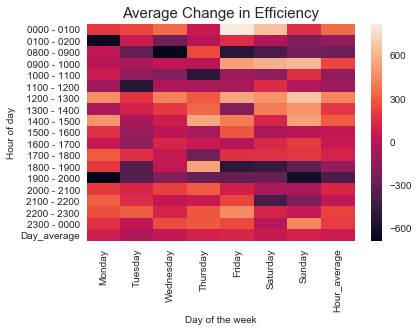

In [83]:

heatmap_efficiency_delta = delta.rename(columns = convert_day)

ax = plt.axes()
sns.heatmap(heatmap_efficiency_delta, ax=ax)

ax.set_title('Average Change in Efficiency', fontsize=15)
ax.set_xlabel("Day of the week", fontsize = 10)
ax.set_ylabel("Hour of day", fontsize = 10)

plt.show()

# Lets try to give weights to some variables

In [215]:
df = pd.read_csv('AirportWaitTimes_new.csv')
df['Date_new'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date_new'].dt.month
df['Day'] = df['Date_new'].dt.day
df['Day_of_week'] = df['Date_new'].dt.weekday
df['Actual'] = df['Total']-df['Excluded']
df = df[(df['Average Wait Time'] != 0 ) & (df['Booths'] != 0)]

df['Metric:Efficiency1'] = (df['Average Wait Time']*(df['Actual']))/df['Booths']

df = df.reset_index(inplace = False, drop = True)
df['Total Time'] = df['Average Wait Time']*df['Actual']

weighted = df

# This penalization method is very much up to how one can transfer the setiment to weights
weighted['16-30'] = weighted['16-30']*np.exp(0.25)
weighted['31-45'] = weighted['31-45']*np.exp(0.75)
weighted['46-60'] = weighted['46-60']*np.exp(1.75)
weighted['61-90'] = weighted['61-90']*np.exp(2.50)
weighted['91-120'] = weighted['91-120']*np.exp(3.0)
weighted['120 plus'] = weighted['120 plus']*np.exp(3.25)



In [216]:
weighted['weighted_passengers'] = weighted['0-15'] + weighted['16-30'] + weighted['31-45'] + weighted['46-60'] + weighted['61-90'] + weighted['91-120'] +weighted['120 plus']


In [217]:
weighted['Metric:Efficiency2'] = (weighted['weighted_passengers']*weighted['Average Wait Time']) / weighted['Booths']

In [218]:
efficiency_table_weighted = round(weighted.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency2']).unstack()
efficiency_table_weighted  = efficiency_table_weighted.drop('0200 - 0300', axis = 0)
efficiency_table_weighted.fillna(efficiency_table_weighted.loc['0100 - 0200'].dropna().mean(), inplace =True)

def highlight_min(s):    
    is_min = s <= np.percentile(efficiency_table_weighted.values.reshape(1,-1), 25) # efficiency score of roughly 375
    return ['background-color: orange' if v else '' for v in is_min]

def highlight_max(s):   
    is_max = s >= np.percentile(efficiency_table_weighted.values.reshape(1,-1), 75)
    return ['background-color: red' if v else '' for v in is_max]

def max_val(s):    
    is_max = s >= np.percentile(efficiency_table_weighted.values.reshape(1,-1), 99)
    return ['background-color: cyan' if v else '' for v in is_max]

def min_val(s):    
    is_max = s <= np.percentile(efficiency_table_weighted.values.reshape(1,-1), 1)
    return ['background-color: lightgreen' if v else '' for v in is_max]

In [219]:
efficiency_table_weighted

Day_of_week,0,1,2,3,4,5,6
Hour,,,,,,,
0000 - 0100,333.0,802.0,354.0,320.0,1453.0,2983.0,260.0
0100 - 0200,587.0,415.0,507.0,411.0,296.0,363.0,298.0
0800 - 0900,1902.0,8916.0,6266.0,3768.0,2379.0,2779.0,1533.0
0900 - 1000,3695.0,4089.0,3911.0,3045.0,2701.0,4750.0,2454.0
1000 - 1100,2565.0,3491.0,2681.0,4029.0,1966.0,4487.0,1429.0
1100 - 1200,1524.0,2132.0,539.0,1219.0,400.0,1009.0,898.0
1200 - 1300,4206.0,3304.0,3014.0,4465.0,2440.0,3163.0,2341.0
1300 - 1400,2834.0,3850.0,1819.0,3335.0,2228.0,2323.0,2518.0
1400 - 1500,2325.0,2689.0,1327.0,3571.0,2528.0,1368.0,1955.0


In [220]:
b= efficiency_table_weighted
b = b.rename(columns = convert_day)
b['Hour_average'] =b.mean(axis =1)
b.loc['Day_average'] = b.mean()

In [221]:
b.rename(columns = convert_day).style.apply(highlight_max).apply(max_val).apply(highlight_min).apply(min_val)




Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Hour_average
Hour,,,,,,,,
0000 - 0100,333,802,354,320,1453,2983,260,929.286
0100 - 0200,587,415,507,411,296,363,298,411
0800 - 0900,1902,8916,6266,3768,2379,2779,1533,3934.71
0900 - 1000,3695,4089,3911,3045,2701,4750,2454,3520.71
1000 - 1100,2565,3491,2681,4029,1966,4487,1429,2949.71
1100 - 1200,1524,2132,539,1219,400,1009,898,1103
1200 - 1300,4206,3304,3014,4465,2440,3163,2341,3276.14
1300 - 1400,2834,3850,1819,3335,2228,2323,2518,2701
1400 - 1500,2325,2689,1327,3571,2528,1368,1955,2251.86


In [ ]:
weighted['weighted_passengers']

In [ ]:
additional.groupby(['Hour']).count()

In [78]:
a= round(additional.groupby(['Hour','Day_of_week']).mean()['Metric:Efficiency1']).unstack()
a= a.drop('0200 - 0300', axis = 0)
a= a.drop('0600 - 0700', axis = 0)
a= a.drop('0700 - 0800', axis = 0)


a['Hour_average'] =a.rename(columns = convert_day).mean(axis =1)
a = a.rename(columns = convert_day)
a.loc['Day_average'] = a.mean()
a.style.apply(highlight_min).apply(highlight_max).apply(min_val).apply(max_val)

Day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Hour_average
Hour,,,,,,,,
0000 - 0100,267,269,432,329,339,333,375,334.857
0100 - 0200,297,405,293,263,236,222,197,273.286
0800 - 0900,413,334,447,357,498,560,551,451.429
0900 - 1000,828,882,893,798,787,873,810,838.714
1000 - 1100,710,862,811,805,860,997,859,843.429
1100 - 1200,596,621,481,724,658,586,699,623.571
1200 - 1300,774,813,727,739,726,849,750,768.286
1300 - 1400,852,614,714,743,785,882,780,767.143
1400 - 1500,565,540,450,599,553,614,625,563.714


In [112]:
outlier[(outlier['Hour'] == '0000 - 0100') &(outlier['Day_of_week'] == 6)]

,Airport,Terminal,Date,Hour,Average Wait Time,Max Wait Time,0-15,16-30,31-45,46-60,...,Total,Flights,Booths,Date_new,Month,Day,Day_of_week,Actual,Metric:Efficiency1,Total Time


In [116]:
df = pd.read_csv('AirportWaitTimes_new.csv')
df['Date_new'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date_new'].dt.month
df['Day'] = df['Date_new'].dt.day
df['Day_of_week'] = df['Date_new'].dt.US.
df['Actual'] = df['Total']-df['Excluded']
#df = df[(df['Average Wait Time'] != 0 ) & (df['Booths'] != 0)]

df['Metric:Efficiency1'] = (df['Average Wait Time']*(df['Total']))/df['Booths']

df = df.reset_index(inplace = False, drop = True)
df[(df['Hour'] == '0000 - 0100') &(df['Day_of_week'] == 6)]

,Airport,Terminal,Date,Hour,Average Wait Time,Max Wait Time,0-15,16-30,31-45,46-60,...,Excluded,Total,Flights,Booths,Date_new,Month,Day,Day_of_week,Actual,Metric:Efficiency1
0,SFO,Terminal A,2017-01-01,0000 - 0100,7,17,111,8,0,0,...,4,123,1,8,2017-01-01,1,1,6,119,107.625000
104,SFO,Terminal A,2017-01-08,0000 - 0100,11,25,102,40,0,0,...,5,147,1,8,2017-01-08,1,8,6,142,202.125000
332,SFO,Terminal A,2017-01-22,0000 - 0100,4,11,105,0,0,0,...,7,112,1,12,2017-01-22,1,22,6,105,37.333333
819,SFO,Terminal A,2017-02-19,0000 - 0100,7,16,82,4,0,0,...,5,91,1,9,2017-02-19,2,19,6,86,70.777778
1065,SFO,Terminal A,2017-03-05,0000 - 0100,8,21,29,13,0,0,...,2,44,1,5,2017-03-05,3,5,6,42,70.400000
1183,SFO,Terminal A,2017-03-12,0000 - 0100,11,39,174,52,9,0,...,13,248,2,7,2017-03-12,3,12,6,235,389.714286
1303,SFO,Terminal A,2017-03-19,0000 - 0100,14,28,67,49,0,0,...,4,120,1,10,2017-03-19,3,19,6,116,168.000000
1425,SFO,Terminal A,2017-03-26,0000 - 0100,14,33,137,84,22,0,...,10,253,2,7,2017-03-26,3,26,6,243,506.000000
2408,SFO,Terminal A,2018-03-11,0000 - 0100,10,29,172,60,0,0,...,13,245,2,9,2018-03-11,3,11,6,232,272.222222
2502,SFO,Terminal A,2018-03-18,0000 - 0100,10,25,189,52,0,0,...,10,251,2,9,2018-03-18,3,18,6,241,278.888889


In [204]:
outlier[(outlier['Hour'] == '1800 - 1900') & (outlier['Day_of_week'] == 6)]

,Airport,Terminal,Date,Hour,Average Wait Time,Max Wait Time,0-15,16-30,31-45,46-60,...,Total,Flights,Booths,Date_new,Month,Day,Day_of_week,Actual,Metric:Efficiency1,Total Time
463,SFO,Terminal A,2017-02-05,1800 - 1900,54,160,212,210,123,58,...,1030,5,17,2017-02-05,2,5,6,988,3138.352941,53352
1299,SFO,Terminal A,2018-01-14,1800 - 1900,41,103,267,392,147,109,...,1334,6,18,2018-01-14,1,14,6,1282,2920.111111,52562
1476,SFO,Terminal A,2018-01-28,1800 - 1900,38,105,397,343,240,190,...,1635,7,18,2018-01-28,1,28,6,1572,3318.666667,59736
1568,SFO,Terminal A,2018-02-04,1800 - 1900,41,124,191,252,85,60,...,872,4,11,2018-02-04,2,4,6,841,3134.636364,34481
